In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import gc
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from random import shuffle
from scipy.stats import spearmanr

from access_biology_data import lincs, properties
from access_science_shared import standardizer

sys.path.append('./../src/')
from aging_tools import inout, export

from access_biology_data import annotation
from access_biology_data import meta

In [4]:
outfolder = '200616_gtex_with_self_controls_all'

# Note

#here the "no brain" is all samples, including brain

In [5]:
save_images = False

In [6]:
ref_genes = standardizer.reference_genes(9606, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [7]:
import glob

In [8]:
p =export.get_material_path(
    '200612_cache_gtex_self_controls/stats_on_imbalance_self_controls.xlsx')

d_self = pd.read_excel(p)

In [9]:
p =export.get_material_path(
    '200518_chache_tstoeger_gtex_with_tilt/stats_on_imbalance.xlsx')

In [10]:
d = pd.read_excel(p)

In [11]:
d.head()

,condition,tilt,pval,tilt_orp,pval_orp,gender,tissue,younger,older
0,females_Adipose_Subcutaneous_3_vs_2,0.249538,3.174345e-214,0.249538,3.174345e-214,female,Adipose - Subcutaneous,2,3
1,females_Adipose_Subcutaneous_4_vs_2,0.172692,2.502136e-102,0.172692,2.502136e-102,female,Adipose - Subcutaneous,2,4
2,females_Adipose_Subcutaneous_4_vs_3,-0.133498,1.728639e-63,-0.133498,1.728639e-63,female,Adipose - Subcutaneous,3,4
3,females_Adipose_Subcutaneous_5_vs_2,0.075904,5.313325e-21,0.075904,5.313325e-21,female,Adipose - Subcutaneous,2,5
4,females_Adipose_Subcutaneous_5_vs_3,-0.216723,3.702485e-162,-0.216723,3.702485e-162,female,Adipose - Subcutaneous,3,5


In [12]:
d = d.rename(columns={'tilt': 'rho', 'tissue': 'region'})

In [13]:
d['gender'] = d['gender'] + 's'

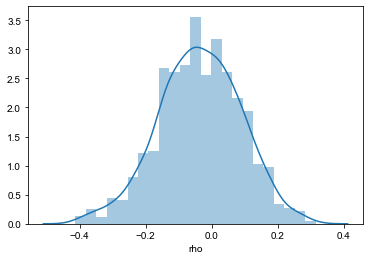

In [14]:
sns.distplot(d['rho'])

In [15]:
agg = []

for gender in ['males', 'females']:

    s = d[(d['gender']==gender)].copy()

    f = (s['younger'].isin([2, 3]) & s['older'].isin([4, 5]))
    s.loc[f, 'cat'] = '20/30 to 40/50'

    f = (s['younger'].isin([4, 5]) & s['older'].isin([6, 7]))
    s.loc[f, 'cat'] = '40/50 to 60/70'

    f = (s['younger'].isin([2, 3]) & s['older'].isin([6, 7]))
    s.loc[f, 'cat'] = '20/30 to 60/70'

    s = s.dropna(subset=['cat'])

    s = s[['pval', 'region', 'cat', 'rho']].groupby(['region', 'cat']).agg(np.median)

    s = s.reset_index()
    comparisons_per_tissue = s['region'].value_counts()
    
    # only consider, if all thre age comparisons are there
    s = s[s['region'].isin(comparisons_per_tissue[comparisons_per_tissue==3].index)]

    order = s[['region', 'rho']].groupby('region').agg(np.median).sort_values('rho')

    hue_order=['20/30 to 40/50','20/30 to 60/70', '40/50 to 60/70', ]

#     plt.figure(figsize=(5, 10))
#     sns.swarmplot(x='rho', y='region',data=s, hue='cat',
#                 order=order[order.index.str.startswith('Brain')].index,
#                 hue_order=hue_order
#                  )
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     if save_images:
#         export.export_image(
#             '{}/{}_brain.pdf'.format(
#                 outfolder,
#                 gender))

#     plt.figure(figsize=(5, 10))
#     sns.swarmplot(x='rho', y='region',data=s, hue='cat',
#                 order=order[~order.index.str.startswith('Brain')].index,
#                 hue_order=hue_order
#                  )
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     if save_images:
#         export.export_image(
#             '{}/{}_non_brain.pdf'.format(
#                 outfolder,
#                 gender))

#     plt.figure(figsize=(5, 10))
#     sns.swarmplot(x='rho', y='region',data=s, hue='cat',
#                 order=order.index,
#                 hue_order=hue_order
#                  )
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     if save_images:
#         export.export_image(
#             '{}/{}_all.pdf'.format(
#                 outfolder,
#                 gender))
        
#     if save_images:
#         export.export_full_frame(
#             '{}/{}_all.xlsx'.format(
#                     outfolder,
#                     gender), 
#             s)
        
#         export.export_full_frame(
#             '{}/{}_young_to_old.xlsx'.format(
#                     outfolder,
#                     gender), 
#             s[s['cat']=='20/30 to 60/70'])  
        
    s.loc[:, 'gender'] = gender
    agg.append(s)

In [16]:
d['younger'].value_counts()

2    375
3    285
4    247
5    158
6     70
Name: younger, dtype: int64

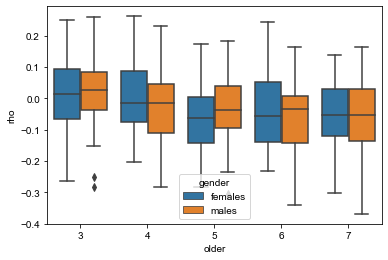

In [17]:
sns.boxplot(
    x='older',
    y='rho',
    data=d[d['younger']==2],
    hue='gender'

)

In [18]:
e = pd.concat(agg)

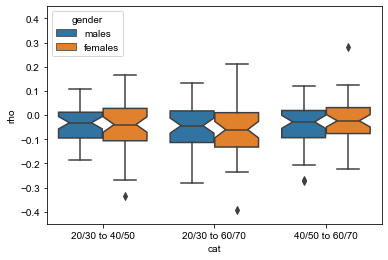

In [19]:
sns.boxplot(x='cat', y='rho', data=e, hue='gender', notch=True)
plt.ylim(-0.45, 0.45)

if save_images:
    export.export_image(
        '{}/notched_box_by_third.pdf'.format(
            outfolder))

In [20]:
a = e.copy()
b = e[e['region'].str.startswith('Brain -')].copy()

a.loc[:, 'is_brain'] = False
b.loc[:, 'is_brain'] = True

e = pd.concat([a, b])

e['is_brain'] = e['is_brain'].astype(float)

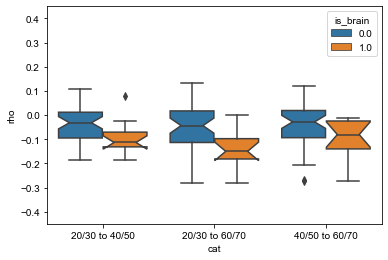

In [21]:
sns.boxplot(x='cat', y='rho', data=e[e['gender']=='males'], hue='is_brain', notch=True)

plt.ylim(-0.45, 0.45)



if save_images:
    export.export_image(
        '{}/notched_box_by_male_brain.pdf'.format(
            outfolder))

In [22]:
e.head()

,region,cat,pval,rho,gender,is_brain
0,Adipose - Subcutaneous,20/30 to 40/50,7.191124e-15,-0.065502,males,0.0
1,Adipose - Subcutaneous,20/30 to 60/70,1.471450e-07,-0.045182,males,0.0
2,Adipose - Subcutaneous,40/50 to 60/70,2.827284e-01,0.004371,males,0.0
3,Adipose - Visceral (Omentum),20/30 to 40/50,1.539068e-03,-0.031697,males,0.0
4,Adipose - Visceral (Omentum),20/30 to 60/70,2.321502e-01,-0.010010,males,0.0


In [23]:
d_self['tissue'].isin(e['region']).mean()

0.9551515151515152

In [24]:
e_self = d_self.copy()

In [25]:
a = e_self.copy()
b = e_self[e_self['tissue'].str.startswith('Brain -')].copy()

a.loc[:, 'is_brain'] = False
b.loc[:, 'is_brain'] = True

In [26]:
e_self = pd.concat([a, b])

In [27]:
# e['is_brain'] = e['is_brain'].astype(float)

In [28]:
e_self['cat'] = e_self['decade'].apply(lambda x: 'self_{}'.format(int(np.floor(x/2)*2)))

In [29]:
e_self['gender'] = e_self['gender'] + 's'

In [30]:
# e_self['is_brain'] = e_self['tissue'].str.contains('Brain')

In [31]:
e_self.head()

,tilt,pval,filename,tissue,decade,animals,gender,is_brain,cat
0,-0.065516,4.540165e-15,Cells - EBV-transformed lymphocytes_pfu_0_age_...,Cells - EBV-transformed lymphocytes,2,7325-7328-7333,males,False,self_2
1,-0.037973,3.226309e-06,Brain - Frontal Cortex (BA9)_pfu_0_age_5_first...,Brain - Frontal Cortex (BA9),5,2982-3009-3016,males,False,self_4
2,-0.307859,0.000000e+00,Lung_pfu_0_age_2_first_7249-7251-7252_DE.csv,Lung,2,7249-7251-7252,males,False,self_2
3,0.007082,3.729493e-01,Liver_pfu_0_age_5_first_3480-3484-3491_DE.csv,Liver,5,3480-3484-3491,males,False,self_4
4,-0.203250,6.654900e-146,Prostate_pfu_0_age_6_first_1237-1295-1302_DE.csv,Prostate,6,1237-1295-1302,males,False,self_6


In [32]:
e_self = e_self.rename(columns={'tissue': 'region', 'tilt': 'rho'})

In [33]:
e_self = pd.merge(e_self, e[['gender', 'region']].drop_duplicates())

In [34]:
e.head()

,region,cat,pval,rho,gender,is_brain
0,Adipose - Subcutaneous,20/30 to 40/50,7.191124e-15,-0.065502,males,0.0
1,Adipose - Subcutaneous,20/30 to 60/70,1.471450e-07,-0.045182,males,0.0
2,Adipose - Subcutaneous,40/50 to 60/70,2.827284e-01,0.004371,males,0.0
3,Adipose - Visceral (Omentum),20/30 to 40/50,1.539068e-03,-0.031697,males,0.0
4,Adipose - Visceral (Omentum),20/30 to 60/70,2.321502e-01,-0.010010,males,0.0


In [35]:
e_median = e_self[['region', 'cat', 'pval', 'rho', 'gender', 'is_brain']].groupby(
    ['region', 'cat']
).median().reset_index()

In [36]:
e_median['cat'] = e_median['cat'] + '_median'

In [37]:
e_self_mask = e_self.copy()
e_self_mask['is_brain'] = False

In [38]:
e_median_mask = e_median.copy()
e_median_mask['is_brain'] = False

In [39]:
# me = pd.concat([
#     e,
#     e_self[['region', 'cat', 'pval', 'rho', 'gender', 'is_brain']],
#     e_median
# ]

# )

In [40]:
me = pd.concat([
    e,
    e_self_mask[['region', 'cat', 'pval', 'rho', 'gender', 'is_brain']],
    e_median_mask
]

)

In [41]:
e[
    (e['is_brain']==False) &
    (e['cat']=='20/30 to 40/50')
].shape

(86, 6)

In [42]:
e[
    (e['is_brain']==False) &
    (e['cat']=='20/30 to 40/50') &
    (e['region'].str.startswith('Brain'))
].shape

(24, 6)

In [43]:
e[
    (e['is_brain']==False) &
    (e['cat']=='20/30 to 60/70')
].shape

(86, 6)

In [44]:
e[
    (e['is_brain']==False) &
    (e['cat']=='20/30 to 60/70') &
    (e['region'].str.startswith('Brain'))
].shape

(24, 6)

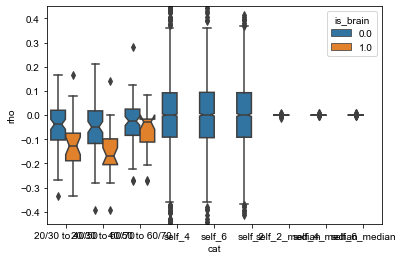

In [45]:
sns.boxplot(x='cat', y='rho', data=me, hue='is_brain', notch=True)
plt.ylim(-0.45, 0.45)

if save_images:
    export.export_image(
        '{}/notched_box_by_third_with_permutations.pdf'.format(
            outfolder))

In [46]:
from scipy.stats import mannwhitneyu

In [47]:
a = me[
    (me['cat']=='20/30 to 40/50') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['cat']=='20/30 to 40/50') &
    (me['is_brain']==True)
]['rho']

mannwhitneyu(b, a, alternative='two-sided')

MannwhitneyuResult(statistic=561.0, pvalue=0.0006608754719616662)

In [48]:
a = me[
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==True)
]['rho']

mannwhitneyu(b, a, alternative='two-sided')

MannwhitneyuResult(statistic=486.0, pvalue=7.876076086639925e-05)

In [49]:
me

,region,cat,pval,rho,gender,is_brain
0,Adipose - Subcutaneous,20/30 to 40/50,7.191124e-15,-6.550172e-02,males,0.0
1,Adipose - Subcutaneous,20/30 to 60/70,1.471450e-07,-4.518232e-02,males,0.0
2,Adipose - Subcutaneous,40/50 to 60/70,2.827284e-01,4.370836e-03,males,0.0
3,Adipose - Visceral (Omentum),20/30 to 40/50,1.539068e-03,-3.169744e-02,males,0.0
4,Adipose - Visceral (Omentum),20/30 to 60/70,2.321502e-01,-1.001044e-02,males,0.0
...,...,...,...,...,...,...
127,Vagina,self_4_median,4.864483e-13,9.733042e-05,NaN,0.0
128,Vagina,self_6_median,3.414095e-12,-5.852924e-05,NaN,0.0
129,Whole Blood,self_2_median,2.805629e-48,4.723603e-07,NaN,0.0
130,Whole Blood,self_4_median,4.423066e-39,-2.054845e-04,NaN,0.0


In [50]:
a = me[
    (me['gender']=='males') &
    (me['cat']=='20/30 to 40/50') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['gender']=='males') &
    (me['cat']=='20/30 to 40/50') &
    (me['is_brain']==True)
]['rho']

mannwhitneyu(b, a, alternative='two-sided')

MannwhitneyuResult(statistic=148.0, pvalue=0.02561981679792919)

In [51]:
a = me[
    (me['gender']=='males') &
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['gender']=='males') &
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==True)
]['rho']

mannwhitneyu(b, a, alternative='two-sided')

MannwhitneyuResult(statistic=121.0, pvalue=0.005398100584023184)

In [52]:
a = me[
    (me['gender']=='females') &
    (me['cat']=='20/30 to 40/50') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['gender']=='females') &
    (me['cat']=='20/30 to 40/50') &
    (me['is_brain']==True)
]['rho']

mannwhitneyu(b, a, alternative='two-sided')

MannwhitneyuResult(statistic=136.0, pvalue=0.013266972438447284)

In [53]:
a = me[
    (me['gender']=='females') &
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['gender']=='females') &
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==True)
]['rho']

mannwhitneyu(b, a, alternative='two-sided')

MannwhitneyuResult(statistic=122.0, pvalue=0.005746929174794822)

In [54]:
a = me[
    (me['cat']=='20/30 to 40/50') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['cat']=='self_2_median') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=1029.0, pvalue=0.0010515644658445884)

In [55]:
a = me[
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['cat']=='self_2_median') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=946.0, pvalue=0.00019438068783932333)

In [56]:
a = me[
    (me['cat']=='20/30 to 40/50') &
    (me['is_brain']==True)
]['rho']

b = me[
    (me['cat']=='self_2_median') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=114.0, pvalue=8.002727848198801e-07)

In [57]:
a = me[
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==True)
]['rho']

b = me[
    (me['cat']=='self_2_median') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=68.0, pvalue=2.1424645391678157e-08)

In [58]:
me['cat'].value_counts()

self_4            4084
self_6            2932
self_2            2198
20/30 to 40/50     110
20/30 to 60/70     110
40/50 to 60/70     110
self_6_median       47
self_4_median       47
self_2_median       38
Name: cat, dtype: int64

In [59]:
me[me['rho'].notnull()]['cat'].value_counts()

self_4            4084
self_6            2932
self_2            2198
20/30 to 40/50     110
20/30 to 60/70     110
40/50 to 60/70     110
self_6_median       47
self_4_median       47
self_2_median       38
Name: cat, dtype: int64

In [60]:
me.groupby(['region', 'cat']).size().to_frame('a').to_csv('/Users/tstoeger/Desktop/tmp.csv')

In [61]:
me.groupby(['cat', 'is_brain']).size()

cat             is_brain
20/30 to 40/50  0.0           86
                1.0           24
20/30 to 60/70  0.0           86
                1.0           24
40/50 to 60/70  0.0           86
                1.0           24
self_2          0.0         2198
self_2_median   0.0           38
self_4          0.0         4084
self_4_median   0.0           47
self_6          0.0         2932
self_6_median   0.0           47
dtype: int64

In [62]:
me.groupby(['cat', 'gender', 'is_brain']).size()

cat             gender   is_brain
20/30 to 40/50  females  0.0           43
                         1.0           12
                males    0.0           43
                         1.0           12
20/30 to 60/70  females  0.0           43
                         1.0           12
                males    0.0           43
                         1.0           12
40/50 to 60/70  females  0.0           43
                         1.0           12
                males    0.0           43
                         1.0           12
self_2          females  0.0          990
                males    0.0         1208
self_4          females  0.0         1926
                males    0.0         2158
self_6          females  0.0         1230
                males    0.0         1702
dtype: int64

In [63]:
me[me['cat']=='self_2_median']['region'].nunique()

38

In [64]:
# a = me[
#     me['cat'].isin(['20/30 to 40/50', '20/30 to 60/70'])][
#         ['region', 'cat', 'gender']
# ].drop_duplicates()

# a[a['region']=='Vagina']

# a.sort_values(['gender', 'region', 'cat']).to_csv('/Users/tstoeger/Desktop/control_count.csv')

In [65]:
a = me[
    (me['cat']=='20/30 to 40/50') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['cat']=='self_2') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=75430.0, pvalue=0.0014684625709692075)

In [66]:
# a = me[
#     (me['cat']=='20/30 to 40/50') &
#     (me['is_brain']==True)
# ]['rho']

# b = me[
#     (me['cat']=='self_2') &
#     (me['is_brain']==True)
# ]['rho']

# mannwhitneyu(a, b, alternative='two-sided')

In [67]:
a = me[
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['cat']=='self_2') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=71490.0, pvalue=0.00012426009932703318)

In [68]:
a = me[
    (me['cat']=='20/30 to 40/50') &
    (me['is_brain']==True)
]['rho']

b = me[
    (me['cat']=='self_2') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=12290.0, pvalue=6.611756691919073e-06)

In [69]:
a = me[
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==True)
]['rho']

b = me[
    (me['cat']=='self_2') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=9477.0, pvalue=6.456631956656037e-08)

In [70]:
e_self['cat'].value_counts()

self_4    4084
self_6    2932
self_2    2198
Name: cat, dtype: int64

In [71]:
a = me[
    (me['cat']=='20/30 to 60/70') &
    (me['is_brain']==False)
]['rho']

b = me[
    (me['cat']=='self_2') &
    (me['is_brain']==False)
]['rho']

mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=71490.0, pvalue=0.00012426009932703318)

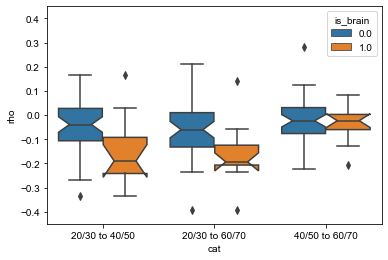

In [72]:
sns.boxplot(x='cat', y='rho', data=e[e['gender']=='females'], hue='is_brain', notch=True)
plt.ylim(-0.45, 0.45)

if save_images:
    export.export_image(
        '{}/notched_box_by_female_brain.pdf'.format(
            outfolder))

In [73]:
e

,region,cat,pval,rho,gender,is_brain
0,Adipose - Subcutaneous,20/30 to 40/50,7.191124e-15,-0.065502,males,0.0
1,Adipose - Subcutaneous,20/30 to 60/70,1.471450e-07,-0.045182,males,0.0
2,Adipose - Subcutaneous,40/50 to 60/70,2.827284e-01,0.004371,males,0.0
3,Adipose - Visceral (Omentum),20/30 to 40/50,1.539068e-03,-0.031697,males,0.0
4,Adipose - Visceral (Omentum),20/30 to 60/70,2.321502e-01,-0.010010,males,0.0
...,...,...,...,...,...,...
49,Brain - Putamen (basal ganglia),20/30 to 60/70,3.269579e-73,-0.199183,females,1.0
50,Brain - Putamen (basal ganglia),40/50 to 60/70,1.444853e-44,-0.010787,females,1.0
52,Brain - Substantia nigra,20/30 to 40/50,1.002094e-09,-0.097746,females,1.0
53,Brain - Substantia nigra,20/30 to 60/70,1.150969e-12,-0.057102,females,1.0


In [74]:
m = e[
    (e['gender']=='males') &
    (e['is_brain']==False)
]
m_rho = m.pivot(index='region', columns='cat', values='rho').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)
m_pval = m.pivot(index='region', columns='cat', values='pval').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)

In [75]:
if save_images:
    export.export_full_frame(
        '{}/table_imbalance_male.xlsx'.format(outfolder),
        m_rho)
    
    export.export_full_frame(
        '{}/table_pval_male.xlsx'.format(outfolder),
        m_pval)

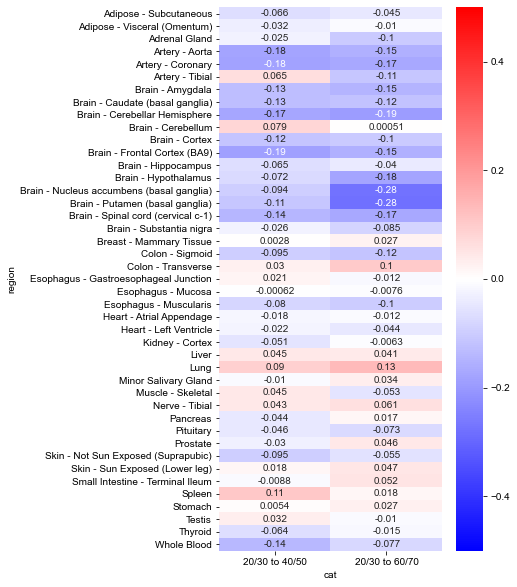

In [76]:
plt.figure(figsize=(5, 10))
sns.heatmap(m_rho, vmin=-0.5, vmax=0.5, cmap='bwr', annot=True)

if save_images:
    export.export_image(
        '{}/table_imbalance_male.pdf'.format(
            outfolder))

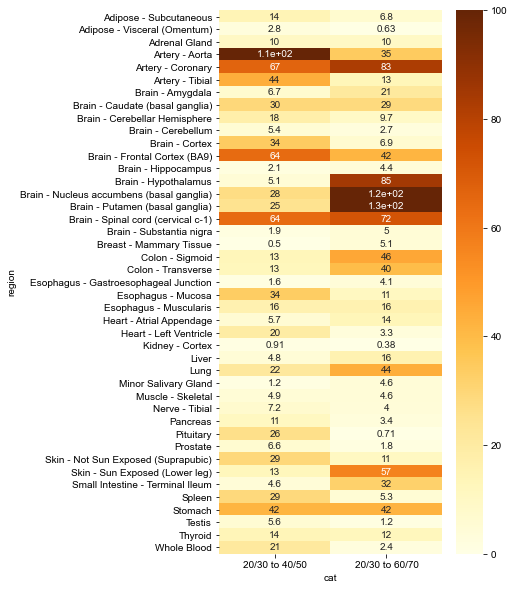

In [77]:
plt.figure(figsize=(5, 10))
sns.heatmap(m_pval.apply(lambda x: -np.log10(x)), annot=True, vmin=0, vmax=100, cmap='YlOrBr')


if save_images:
    export.export_image(
        '{}/table_pval_male.pdf'.format(
            outfolder))

In [78]:
m = e[
    (e['gender']=='females') & 
    (e['is_brain']==False)
]
m_rho = m.pivot(index='region', columns='cat', values='rho').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)
m_pval = m.pivot(index='region', columns='cat', values='pval').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)

In [79]:
if save_images:
    export.export_full_frame(
        '{}/table_imbalance_female.xlsx'.format(outfolder),
        m_rho)
    
    export.export_full_frame(
        '{}/table_pval_female.xlsx'.format(outfolder),
        m_pval)

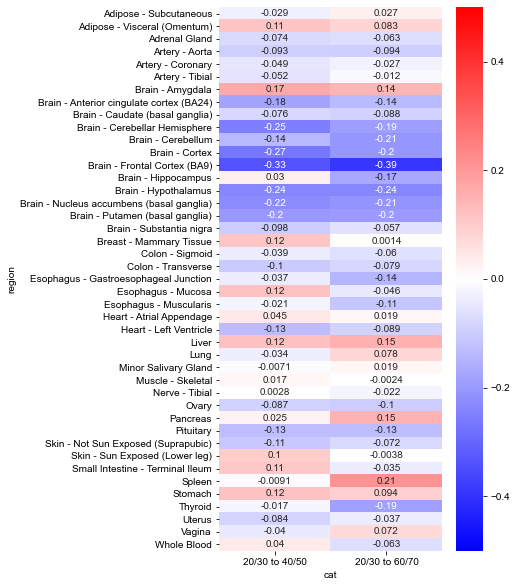

In [80]:
plt.figure(figsize=(5, 10))
sns.heatmap(m_rho, vmin=-0.5, vmax=0.5, cmap='bwr', annot=True)

if save_images:
    export.export_image(
        '{}/table_imbalance_female.pdf'.format(
            outfolder))

In [81]:
if save_images:
    export.export_image(
        '{}/table_pval_female.pdf'.format(
            outfolder))

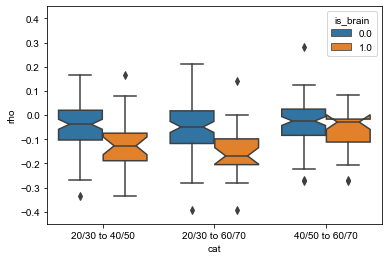

In [82]:
sns.boxplot(x='cat', y='rho', data=e, hue='is_brain', notch=True)
plt.ylim(-0.45, 0.45)


if save_images:
    export.export_image(
        '{}/notched_box_by_brain.pdf'.format(
            outfolder))

In [83]:
e.groupby(['cat', 'is_brain']).size()

cat             is_brain
20/30 to 40/50  0.0         86
                1.0         24
20/30 to 60/70  0.0         86
                1.0         24
40/50 to 60/70  0.0         86
                1.0         24
dtype: int64

In [84]:
e.groupby(['cat', 'is_brain', 'gender']).size()

cat             is_brain  gender 
20/30 to 40/50  0.0       females    43
                          males      43
                1.0       females    12
                          males      12
20/30 to 60/70  0.0       females    43
                          males      43
                1.0       females    12
                          males      12
40/50 to 60/70  0.0       females    43
                          males      43
                1.0       females    12
                          males      12
dtype: int64

In [85]:
if save_images:
    export.export_full_frame(
        '{}/summary_stats.xlsx'.format(outfolder), e)

In [86]:
from scipy.stats import mannwhitneyu

In [87]:
def comp(t):
    a = t[t['cat']=='20/30 to 40/50']['rho']
    b = t[t['cat']=='20/30 to 60/70']['rho']
    
    _, p = mannwhitneyu(a, b, alternative='two-sided')
    print(p)
    return

In [88]:
comp(e[e['is_brain']==True])

0.3273658351959313


In [89]:
comp(e[(e['is_brain']==True) & (e['gender']=='males')])

0.1748533068932927


In [90]:
comp(e[(e['is_brain']==True) & (e['gender']=='females')])

0.8398599725400034


In [91]:
d.loc[:, 'is_brain'] = d.loc[:, 'region'].str.startswith('Brain_') == True

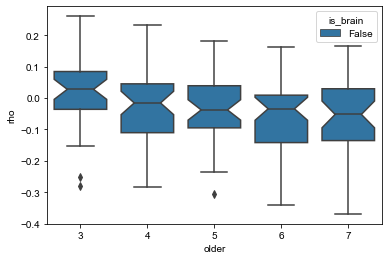

In [92]:
sns.boxplot(
    x='older',
    y='rho',
    data=d[(d['younger'].isin([2])) & (d['gender']=='males')],
    hue='is_brain',
    notch=True
)



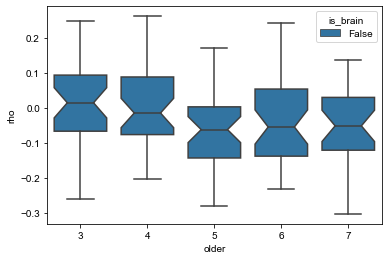

In [93]:
sns.boxplot(
    x='older',
    y='rho',
    data=d[(d['younger'].isin([2])) & (d['gender']=='females')],
    hue='is_brain',
    notch=True
)



In [94]:
def comp(t, s):
    a = t[(t['cat']==s) & (t['is_brain']==True)]['rho']
    b = t[(t['cat']==s) & (t['is_brain']==False)]['rho']
    
    _, p = mannwhitneyu(a, b, alternative='two-sided')
    print(p)
    return

In [95]:
comp(e, '20/30 to 40/50')

0.0006608754719616662


In [96]:
comp(e, '20/30 to 60/70')

7.876076086639925e-05
